In [12]:
import os

project_path = "/content/drive/MyDrive/GarpageProject"
os.makedirs(project_path, exist_ok=True)

In [15]:
!kaggle datasets download -d asdasdasasdas/garbage-classification

Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
  0% 0.00/82.0M [00:00<?, ?B/s]
100% 82.0M/82.0M [00:00<00:00, 1.42GB/s]


In [ ]:
!unzip garbage-classification.zip 

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/GarbageProject/Garbage classification/Garbage classification/cardboard/cardboard23.jpg  
  inflating: /content/drive/MyDrive/GarbageProject/Garbage classification/Garbage classification/cardboard/cardboard230.jpg  
  inflating: /content/drive/MyDrive/GarbageProject/Garbage classification/Garbage classification/cardboard/cardboard231.jpg  
  inflating: /content/drive/MyDrive/GarbageProject/Garbage classification/Garbage classification/cardboard/cardboard232.jpg  
  inflating: /content/drive/MyDrive/GarbageProject/Garbage classification/Garbage classification/cardboard/cardboard233.jpg  
  inflating: /content/drive/MyDrive/GarbageProject/Garbage classification/Garbage classification/cardboard/cardboard234.jpg  
  inflating: /content/drive/MyDrive/GarbageProject/Garbage classification/Garbage classification/cardboard/cardboard235.jpg  
  inflating: /content/drive/MyDrive/GarbageProject/Garbage classific

In [17]:
!pip install torch torchvision timm

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import convnext_tiny

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
data_dir = "Garbage-classification/Garbage classification"
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

num_classes = len(full_dataset.classes)
print("Number of classes:", num_classes)

Number of classes: 6


In [9]:
from torchvision.models import efficientnet_v2_s

model = efficientnet_v2_s(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 186MB/s]


In [10]:
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

In [19]:
for param in model.parameters():
    param.requires_grad = False

In [20]:
import numpy as np
import torch.nn as nn

class_counts = np.array([403, 501, 410, 594, 482, 137])

weights = 1. / class_counts
weights = weights / weights.sum()

class_weights = torch.tensor(weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [23]:
import torch.optim as optim

optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)


In [25]:
scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-2340218076.py:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [27]:
best_acc = 0
epochs = 10

for epoch in range(epochs):

    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # -------- Validation --------

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total

    scheduler.step(val_acc)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("🔥 Best model saved!")

/tmp/ipython-input-1652393931.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/10]
Train Loss: 0.5558
Validation Accuracy: 90.12%
🔥 Best model saved!
Epoch [2/10]
Train Loss: 0.1918
Validation Accuracy: 93.28%
🔥 Best model saved!
Epoch [3/10]
Train Loss: 0.1023
Validation Accuracy: 95.65%
🔥 Best model saved!
Epoch [4/10]
Train Loss: 0.0694
Validation Accuracy: 95.45%
Epoch [5/10]
Train Loss: 0.0595
Validation Accuracy: 94.86%
Epoch [6/10]
Train Loss: 0.0552
Validation Accuracy: 94.47%
Epoch [7/10]
Train Loss: 0.0479
Validation Accuracy: 95.26%
Epoch [8/10]
Train Loss: 0.0232
Validation Accuracy: 96.25%
🔥 Best model saved!
Epoch [9/10]
Train Loss: 0.0249
Validation Accuracy: 95.45%
Epoch [10/10]
Train Loss: 0.0264
Validation Accuracy: 95.45%


In [28]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

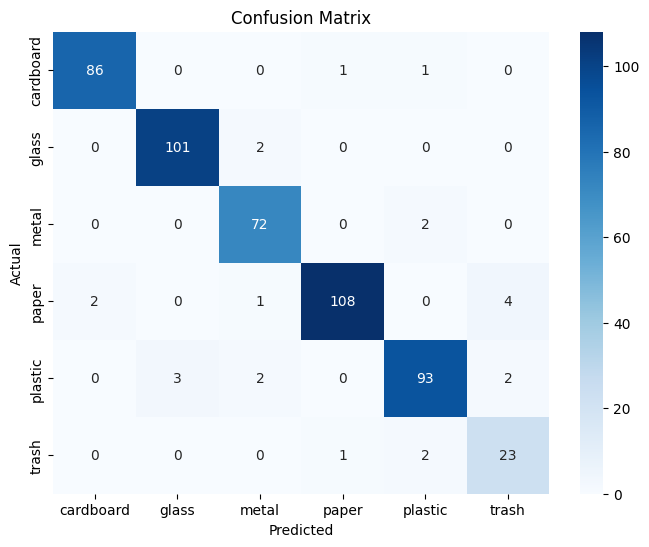

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=full_dataset.classes,
            yticklabels=full_dataset.classes)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [31]:
print(classification_report(all_labels, all_preds,
                            target_names=full_dataset.classes))

              precision    recall  f1-score   support

   cardboard       0.98      0.98      0.98        88
       glass       0.97      0.98      0.98       103
       metal       0.94      0.97      0.95        74
       paper       0.98      0.94      0.96       115
     plastic       0.95      0.93      0.94       100
       trash       0.79      0.88      0.84        26

    accuracy                           0.95       506
   macro avg       0.93      0.95      0.94       506
weighted avg       0.96      0.95      0.95       506

